In [1]:
import os
import mediapipe as mp
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import cv2
from jiwer import wer

In [2]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [2]:
mpFaceDetection = mp.solutions.face_detection
faceDetection = mpFaceDetection.FaceDetection(model_selection=1)

In [20]:
def load_video(path) -> list[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    offy = 30
    offx = 45
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        success, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = faceDetection.process(frame)
        if results.detections:
            for lips in results.detections:
                landmarks = lips.location_data.relative_keypoints
                mouth = (int(landmarks[3].x * frame.shape[1]), int(landmarks[3].y * frame.shape[0]))
                mouth = np.array(mouth)
                x = mouth[0]
                y = mouth[1]
                frames.append(frame[y - offy:y + offy,x - offx:x + offx :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

[array([[[217, 190, 154],
        [217, 190, 154],
        [219, 192, 156],
        ...,
        [219, 196, 156],
        [217, 194, 154],
        [216, 193, 153]],

       [[217, 190, 154],
        [217, 190, 154],
        [218, 191, 155],
        ...,
        [217, 194, 154],
        [217, 194, 154],
        [216, 193, 153]],

       [[217, 189, 151],
        [218, 190, 152],
        [219, 191, 153],
        ...,
        [216, 193, 153],
        [216, 193, 153],
        [215, 192, 152]],

       ...,

       [[ 85,  47,  26],
        [ 83,  45,  24],
        [ 83,  45,  24],
        ...,
        [ 92,  56,  34],
        [ 92,  56,  34],
        [ 92,  56,  34]],

       [[ 84,  48,  26],
        [ 84,  48,  26],
        [ 84,  48,  26],
        ...,
        [ 92,  56,  34],
        [ 93,  57,  35],
        [ 93,  57,  35]],

       [[ 84,  48,  26],
        [ 84,  48,  26],
        [ 84,  48,  26],
        ...,
        [ 92,  56,  34],
        [ 93,  57,  35],
        [ 93,  57,  35]

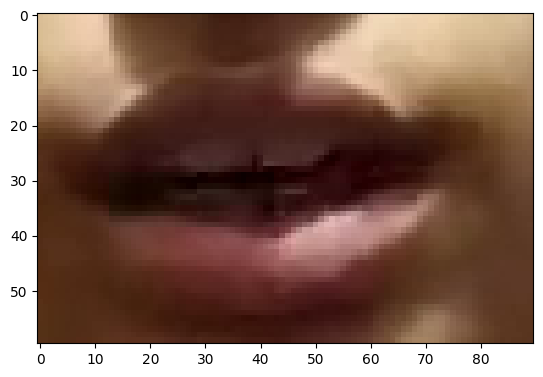

In [19]:
frames=load_video("test/lrwr7n/5.mp4")
print(frames)
plt.imshow(frames[20])
plt.show()

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [37]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [38]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-2].split('.')[0]
    video_path = os.path.join('Data','s2', f'{file_name}.mpg')
    alignment_path = os.path.join('Data','label','s2','align', f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [25]:
test_path = 'Data\\s17\\bbad6n.mpg'

In [8]:
file_name = test_path.split('\\')[-1].split('.')[0]

In [9]:
file_name

'bbaf1n'

In [26]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

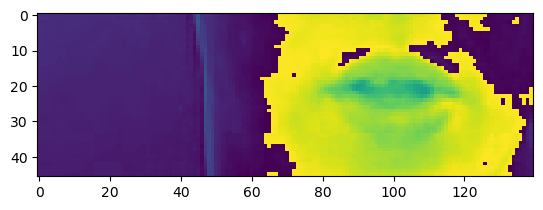

In [27]:
plt.imshow(frames[20])

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  4, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at d six now'>

In [39]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [41]:
data = tf.data.Dataset.list_files('test\\lrwr7n\\*.mp4')
data = data.map(mappable_function)
data = data.padded_batch(1, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

Creating Pipeline

In [8]:
data = tf.data.Dataset.list_files('Data\\s2\\*.mpg')
data = data.shuffle(1000, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(1, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

Splitting the data in train and test

In [9]:
split=int(len(data) * 0.95)
train = data.take(split)
test = data.skip(split)

print(f"Size of the training set: {len(train)}")
print(f"Size of the test set: {len(test)}")

Size of the training set: 950
Size of the test set: 50


In [10]:
train=train.apply(tf.data.experimental.ignore_errors())
test=test.apply(tf.data.experimental.ignore_errors())

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [314]:
frames, alignments = data.as_numpy_iterator().next()

In [324]:
len(frames)

1

In [306]:
sample = data.as_numpy_iterator()

In [307]:
val = sample.next(); val[0]


array([[[[[1.3625883 ],
          [1.3625883 ],
          [1.3625883 ],
          ...,
          [0.47942922],
          [0.50466233],
          [0.50466233]],

         [[1.3625883 ],
          [1.3625883 ],
          [1.3625883 ],
          ...,
          [0.47942922],
          [0.50466233],
          [0.50466233]],

         [[1.2616558 ],
          [1.2616558 ],
          [1.2616558 ],
          ...,
          [0.5551286 ],
          [0.5298954 ],
          [0.5298954 ]],

         ...,

         [[0.9840916 ],
          [0.9840916 ],
          [0.9840916 ],
          ...,
          [6.3839784 ],
          [6.257813  ],
          [6.081181  ]],

         [[0.95885843],
          [0.95885843],
          [0.95885843],
          ...,
          [6.257813  ],
          [6.1316476 ],
          [6.0054817 ]],

         [[0.95885843],
          [0.95885843],
          [0.95885843],
          ...,
          [6.1064143 ],
          [6.030715  ],
          [5.9550157 ]]],


        [[[1.3625

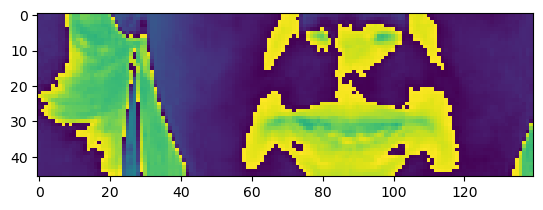

In [34]:
plt.imshow(val[0][0][35])

In [31]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue in z four now'>

In [21]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [37]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [22]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [308]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [309]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'llay  rred   it       sive    soon'>

In [14]:
model.input_shape

(None, 75, 46, 140, 1)

In [15]:
model.output_shape

(None, 75, 41)

In [24]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [25]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [26]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        shuffled_data = self.dataset.shuffle(buffer_size=1)
        data = self.shuffled_data.next()
        yhat = self.model.predict(data[0])
        predictions = []
        targets = []
        decoded = tf.keras.backend.ctc_decode(yhat, [75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            original = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
            targets.append(original)
            prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
            predictions.append(prediction)
        wer_score = wer(targets, predictions)
        print('~'*100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print('~'*100)
        print('Original: ', targets)
        print('Prediction: ', predictions)
        print('~'*100)

In [27]:
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

In [28]:
model.compile(optimizer=optimizer, loss=CTCLoss)


In [29]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [30]:
schedule_callback = LearningRateScheduler(scheduler)


In [33]:
model.load_weights('models\checkpoint')

In [35]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

900/900 [==============================] - 19754s 22s/step - loss: 58.6472 - val_loss: 38.9617 - lr: 1.3534e-05


In [42]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

900/900 [==============================] - 21623s 24s/step - loss: 48.1835 - lr: 1.3534e-05


In [49]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

900/900 [==============================] - 21909s 24s/step - loss: 45.8185 - val_loss: 36.1629 - lr: 1.3534e-05


In [56]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

900/900 [==============================] - 26167s 29s/step - loss: 44.5096 - val_loss: 35.6016 - lr: 1.3534e-05


In [63]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

900/900 [==============================] - 22219s 25s/step - loss: 45.2389 - val_loss: 37.4867 - lr: 1.3534e-05


In [77]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

900/900 [==============================] - 26373s 29s/step - loss: 43.6995 - val_loss: 36.5242 - lr: 1.3534e-05


In [91]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

900/900 [==============================] - 26308s 29s/step - loss: 43.7537 - val_loss: 35.5846 - lr: 1.3534e-05


In [33]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

950/950 [==============================] - 22840s 24s/step - loss: 42.4827 - val_loss: 36.7737 - lr: 1.3534e-05


In [40]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

950/950 [==============================] - 29110s 31s/step - loss: 42.6521 - val_loss: 34.4139 - lr: 1.3534e-05


In [55]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

950/950 [==============================] - 22745s 24s/step - loss: 41.7481 - val_loss: 34.5661 - lr: 1.3534e-05


In [49]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

950/950 [==============================] - 22876s 24s/step - loss: 41.1931 - val_loss: 33.9632 - lr: 1.3534e-05


In [88]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

950/950 [==============================] - 20495s 22s/step - loss: 39.3572 - val_loss: 34.3468 - lr: 1.3534e-05


In [141]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

950/950 [==============================] - 21303s 22s/step - loss: 39.7890 - val_loss: 34.1498 - lr: 1.3534e-05


In [149]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback])

950/950 [==============================] - 23660s 25s/step - loss: 38.0992 - val_loss: 30.6223 - lr: 1.3534e-05


In [207]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 3s 3s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['bin red at f nine please']
Prediction:  ['bin ble it foue please']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 24826s 26s/step - loss: 31.9900 - val_loss: 26.4109 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 3s 3s/steps - loss: 29.654
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.8333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['bin red with a four again']
Prediction:  ['bin blue it fone sgain']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

##################       Testing     ###############################3

In [64]:
shuffled_test = test.shuffle(buffer_size=1)

In [65]:
test_data = shuffled_test.as_numpy_iterator()

In [66]:
sample = test_data.next()

In [38]:
yyhat = model.predict(sample[0])

1/1 [==============================] - 7s 7s/step


In [44]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.7143
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin white sp by f five soon
Prediction:  bin white it p sive non
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [263]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 6s 6s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['place white by d seven please']
Prediction:  ['place white wiy y seve please']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 26710s 28s/step - loss: 42.8390 - val_loss: 32.9485 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 6s 6s/steps - loss: 38.632
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 1.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['place green at k two soon']
Prediction:  ['bin gren it t tiro son']
~~~~~~~~~~~~~~~~~~~~~~~~~~

In [275]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 3s 3s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['set white with p three please']
Prediction:  ['set white bt y tore please']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 23779s 25s/step - loss: 36.7227 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 3s 3s/steps - loss: 33.153
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 1.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['lay red by k nine now']
Prediction:  ['let gren it sirx please']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [291]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 6s 6s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['place white at d one now']
Prediction:  ['place white it tone poe']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 25196s 27s/step - loss: 37.4784 - val_loss: 29.3347 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 3s 3s/steps - loss: 33.635
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.8333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['set green by j one please']
Prediction:  ['set gre it u fone poain']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [299]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 5s 5s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['place white by k two again']
Prediction:  ['bin white by y tine again']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 28992s 31s/step - loss: 37.6720 - val_loss: 32.5845 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 5s 5s/steps - loss: 35.144
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.8333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['bin red with g six soon']
Prediction:  ['bin whie it s sive son']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [310]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 5s 5s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['place red with j nine please']
Prediction:  ['place white by y five please']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 29491s 31s/step - loss: 37.3248 - val_loss: 29.8764 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 5s 5s/steps - loss: 32.434
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['place white in p five now']
Prediction:  ['lay white it fono now']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [317]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 5s 5s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['bin white at a zero soon']
Prediction:  ['bin white it s sire son']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
892/892 [==============================] - 35537s 40s/step - loss: 36.1796 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 4s 4s/steps - loss: 31.001
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 1.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['place green in k zero again']
Prediction:  ['bince gre an x to please']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [325]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 5s 5s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 1.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['place red at v eight soon']
Prediction:  ['bince whie it t sive son']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 25312s 27s/step - loss: 38.8606 - val_loss: 34.5745 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 4s 4s/steps - loss: 35.315
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 1.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['bin red with g seven please']
Prediction:  ['bince blue wit u five aon']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [332]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 5s 5s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['set red at u four again']
Prediction:  ['set white it t tire again']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 27635s 29s/step - loss: 39.1836 - val_loss: 33.0762 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 4s 4s/steps - loss: 35.972
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.8333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['bin red in l eight soon']
Prediction:  ['bin e gren in t tire son']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [340]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5
1/1 [==============================] - 4s 4s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['lay white by l seven please']
Prediction:  ['lay white it p five please']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
950/950 [==============================] - 27621s 29s/step - loss: 39.9859 - val_loss: 31.7160 - lr: 1.3534e-05
Epoch 2/5
1/1 [==============================] - 4s 4s/steps - loss: 36.095
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.8333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['set red with v zero soon']
Prediction:  ['set white by y sie now']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [369]:
model.fit(train, validation_data=test, epochs=2, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/2
950/950 [==============================] - 26955s 28s/step - loss: 21.8625 - val_loss: 17.0218 - lr: 1.3534e-05
Epoch 2/2
950/950 [==============================] - 26092s 27s/step - loss: 20.5669 - val_loss: 15.6783 - lr: 1.3534e-05


In [377]:
model.fit(train, validation_data=test, epochs=4, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/4
950/950 [==============================] - 27310s 29s/step - loss: 32.0901 - val_loss: 25.2565 - lr: 1.3534e-05
Epoch 2/4
950/950 [==============================] - 24554s 26s/step - loss: 29.2648 - val_loss: 22.4012 - lr: 1.3534e-05
Epoch 3/4
950/950 [==============================] - 30722s 32s/step - loss: 26.8231 - val_loss: 21.3489 - lr: 1.3534e-05
Epoch 4/4
950/950 [==============================] - 30602s 32s/step - loss: 24.5439 - val_loss: 20.0600 - lr: 1.3534e-05


In [ ]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 29399s 31s/step - loss: 36.5359 - val_loss: 28.8649 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 31814s 33s/step - loss: 31.7376 - val_loss: 24.9080 - lr: 1.3534e-05
Epoch 3/5
 79/950 [=>............................] - ETA: 4:56:30 - loss: 29.2597

In [30]:
model.fit(train, validation_data=test, epochs=4, callbacks=[checkpoint_callback, schedule_callback])                                                

Epoch 1/4
950/950 [==============================] - 25977s 27s/step - loss: 42.2306 - lr: 1.3534e-05
Epoch 2/4
950/950 [==============================] - 21467s 23s/step - loss: 39.0703 - lr: 1.3534e-05
Epoch 3/4
950/950 [==============================] - 22314s 23s/step - loss: 36.6955 - lr: 1.3534e-05
Epoch 4/4
950/950 [==============================] - 22137s 23s/step - loss: 34.2085 - lr: 1.3534e-05


In [54]:
model.fit(train, validation_data=test, epochs=4, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/4
950/950 [==============================] - 26716s 28s/step - loss: 28.7787 - val_loss: 23.8613 - lr: 1.3534e-05
Epoch 2/4
950/950 [==============================] - 21971s 23s/step - loss: 26.9419 - val_loss: 22.2016 - lr: 1.3534e-05
Epoch 3/4
950/950 [==============================] - 25397s 27s/step - loss: 25.3777 - val_loss: 20.9688 - lr: 1.3534e-05
Epoch 4/4
950/950 [==============================] - 46325s 49s/step - loss: 23.3568 - val_loss: 18.9268 - lr: 1.3534e-05


In [63]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 28522s 30s/step - loss: 35.2051 - val_loss: 26.7298 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 29085s 31s/step - loss: 30.4147 - val_loss: 25.7999 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 31050s 33s/step - loss: 27.6236 - val_loss: 22.3979 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 28191s 30s/step - loss: 24.9170 - val_loss: 18.9000 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 30754s 32s/step - loss: 22.7641 - val_loss: 18.3445 - lr: 1.3534e-05


In [68]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place blue with b five again
Prediction:  place blue it y five agaie
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [75]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 28342s 30s/step - loss: 30.7389 - val_loss: 24.5893 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 27593s 29s/step - loss: 25.8617 - val_loss: 20.9757 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 28791s 30s/step - loss: 23.5466 - val_loss: 18.2883 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 27408s 29s/step - loss: 21.5954 - val_loss: 16.8108 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 27758s 29s/step - loss: 20.2297 - lr: 1.3534e-05


In [79]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.3333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white with j zero again
Prediction:  place white with o foro again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [86]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 27946s 29s/step - loss: 33.7461 - val_loss: 27.9710 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 28692s 30s/step - loss: 28.3057 - val_loss: 21.3023 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 28548s 30s/step - loss: 25.9852 - val_loss: 20.9818 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 29904s 31s/step - loss: 24.1376 - val_loss: 18.9567 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 29240s 31s/step - loss: 22.8698 - val_loss: 18.8758 - lr: 1.3534e-05


In [90]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.3333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay white by d seven again
Prediction:  lay white by p sive again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [97]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 29273s 31s/step - loss: 36.4600 - val_loss: 28.5976 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 29236s 31s/step - loss: 31.9954 - val_loss: 27.0162 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 29206s 31s/step - loss: 29.3237 - val_loss: 22.5731 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 28894s 30s/step - loss: 27.0572 - val_loss: 24.6052 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 29067s 31s/step - loss: 25.0369 - val_loss: 19.1415 - lr: 1.3534e-05


In [101]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.8333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin white with l nine please
Prediction:  set gren it t tine please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 28360s 30s/step - loss: 36.6731 - val_loss: 29.7727 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 30133s 32s/step - loss: 32.9988 - val_loss: 25.8045 - lr: 1.3534e-05
Epoch 3/5
690/950 [====================>.........] - ETA: 2:11:13 - loss: 30.6227

In [112]:
model.fit(train, validation_data=test, epochs=3, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/3
950/950 [==============================] - 20826s 22s/step - loss: 28.5805 - val_loss: 23.9146 - lr: 1.3534e-05
Epoch 2/3
950/950 [==============================] - 19872s 21s/step - loss: 26.2338 - val_loss: 20.0422 - lr: 1.3534e-05
Epoch 3/3
950/950 [==============================] - 24930s 26s/step - loss: 23.9848 - val_loss: 17.1214 - lr: 1.3534e-05


In [116]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.8333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place green with c six soon
Prediction:  place gredn it s sirx son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [124]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 22112s 23s/step - loss: 30.6537 - val_loss: 24.2945 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 20247s 21s/step - loss: 25.5293 - val_loss: 18.8537 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 25468s 27s/step - loss: 22.9066 - val_loss: 19.4655 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 23802s 25s/step - loss: 21.4249 - val_loss: 17.5237 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 21160s 22s/step - loss: 19.8003 - val_loss: 21.3751 - lr: 1.3534e-05


In [128]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.3333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set white by m nine again
Prediction:  set white by y five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [135]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 21282s 22s/step - loss: 29.4475 - val_loss: 20.7547 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 22250s 23s/step - loss: 24.3847 - val_loss: 20.5618 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 21157s 22s/step - loss: 21.6249 - val_loss: 17.1641 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 20522s 22s/step - loss: 19.9131 - val_loss: 16.2042 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 21572s 23s/step - loss: 18.5466 - val_loss: 14.1177 - lr: 1.3534e-05


In [139]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay green in c eight soon
Prediction:  lay gren in a sigh aoin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [146]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 22626s 24s/step - loss: 34.0771 - val_loss: 27.1355 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 22624s 24s/step - loss: 27.9398 - val_loss: 20.5381 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 20300s 21s/step - loss: 25.0182 - val_loss: 22.3450 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 23782s 25s/step - loss: 23.0134 - val_loss: 22.1500 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 21845s 23s/step - loss: 21.0896 - val_loss: 17.3898 - lr: 1.3534e-05


In [150]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place red at g nine again
Prediction:  place red it t tine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [158]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 20910s 22s/step - loss: 34.6859 - val_loss: 26.7947 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 19813s 21s/step - loss: 28.7007 - val_loss: 24.2817 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 21923s 23s/step - loss: 25.6770 - val_loss: 20.2826 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 23080s 24s/step - loss: 23.7419 - val_loss: 21.2586 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 21156s 22s/step - loss: 22.3815 - val_loss: 17.4459 - lr: 1.3534e-05


In [162]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.3333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay red at i three please
Prediction:  lay red at s tere please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [169]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 35626s 38s/step - loss: 35.0273 - val_loss: 25.9557 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 21969s 23s/step - loss: 28.0120 - val_loss: 21.0160 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 20698s 22s/step - loss: 24.4870 - val_loss: 20.2454 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 20254s 21s/step - loss: 21.7337 - val_loss: 16.3187 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 21963s 23s/step - loss: 20.0469 - val_loss: 15.0743 - lr: 1.3534e-05


In [173]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay green with y zero please
Prediction:  lay gren it y five please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [180]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 22151s 23s/step - loss: 40.8142 - val_loss: 33.6370 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 20337s 21s/step - loss: 37.6313 - val_loss: 33.5379 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 21045s 22s/step - loss: 35.5955 - val_loss: 30.6497 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 21798s 23s/step - loss: 33.5347 - val_loss: 29.0860 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 22368s 24s/step - loss: 31.2932 - val_loss: 27.1375 - lr: 1.3534e-05


In [184]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set white at f four soon
Prediction:  set white it s foro now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [191]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 20953s 22s/step - loss: 34.7652 - val_loss: 24.6406 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 21409s 23s/step - loss: 28.5078 - val_loss: 21.7067 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 22082s 23s/step - loss: 25.8080 - val_loss: 23.9041 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 22270s 23s/step - loss: 24.4125 - val_loss: 24.4429 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 21751s 23s/step - loss: 22.8423 - val_loss: 18.6289 - lr: 1.3534e-05


In [195]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay red at b four now
Prediction:  lay red by p fouo now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [202]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 22601s 24s/step - loss: 33.2368 - val_loss: 26.4006 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 23991s 25s/step - loss: 28.8928 - val_loss: 23.1455 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 22047s 23s/step - loss: 26.2523 - val_loss: 21.4509 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 21495s 23s/step - loss: 24.2963 - val_loss: 18.8846 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 23615s 25s/step - loss: 22.4402 - val_loss: 16.3861 - lr: 1.3534e-05


In [206]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white at n one now
Prediction:  place white it o fine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [213]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 23960s 25s/step - loss: 23.7823 - val_loss: 16.6104 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 21947s 23s/step - loss: 18.9139 - val_loss: 15.3090 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 24231s 26s/step - loss: 17.0121 - val_loss: 13.3767 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 26750s 28s/step - loss: 15.7751 - val_loss: 13.1167 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 20958s 22s/step - loss: 14.8680 - val_loss: 11.5239 - lr: 1.3534e-05


In [217]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place blue in s zero please
Prediction:  place blue it s zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [221]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay red with c zero now
Prediction:  lay red with z zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [225]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.3333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white at t five soon
Prediction:  place white at s five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [229]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay red by v zero please
Prediction:  lay red by k zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [236]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
950/950 [==============================] - 20954s 22s/step - loss: 25.7502 - val_loss: 18.0197 - lr: 1.3534e-05
Epoch 2/5
950/950 [==============================] - 23361s 25s/step - loss: 21.4283 - val_loss: 15.3558 - lr: 1.3534e-05
Epoch 3/5
950/950 [==============================] - 24463s 26s/step - loss: 19.3886 - val_loss: 14.8464 - lr: 1.3534e-05
Epoch 4/5
950/950 [==============================] - 22828s 24s/step - loss: 18.0498 - val_loss: 13.9796 - lr: 1.3534e-05
Epoch 5/5
950/950 [==============================] - 21737s 23s/step - loss: 17.0592 - val_loss: 12.4944 - lr: 1.3534e-05


In [239]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.6667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay blue with i zero again
Prediction:  lay red by k zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [290]:
model.fit(train, validation_data=test, epochs=6, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/6
950/950 [==============================] - 24232s 26s/step - loss: 33.9321 - val_loss: 28.6081 - lr: 1.3534e-05
Epoch 2/6
950/950 [==============================] - 23752s 25s/step - loss: 27.6773 - val_loss: 23.9407 - lr: 1.3534e-05
Epoch 3/6
950/950 [==============================] - 22134s 23s/step - loss: 25.0520 - val_loss: 20.2710 - lr: 1.3534e-05
Epoch 4/6
950/950 [==============================] - 23821s 25s/step - loss: 23.2909 - val_loss: 20.2118 - lr: 1.3534e-05
Epoch 5/6
950/950 [==============================] - 22150s 23s/step - loss: 21.5897 - val_loss: 17.9651 - lr: 1.3534e-05
Epoch 6/6
950/950 [==============================] - 23448s 25s/step - loss: 20.8347 - val_loss: 17.7231 - lr: 1.3534e-05


In [294]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.3333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set red by r seven again
Prediction:  set red by y five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [315]:
model.fit(train, validation_data=test, epochs=3, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/3
950/950 [==============================] - 20980s 22s/step - loss: 23.7536 - val_loss: 16.2529 - lr: 1.3534e-05
Epoch 2/3
950/950 [==============================] - 26303s 28s/step - loss: 18.6435 - val_loss: 16.9072 - lr: 1.3534e-05
Epoch 3/3
950/950 [==============================] - 24185s 25s/step - loss: 17.1554 - val_loss: 13.0329 - lr: 1.3534e-05


In [319]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.5000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white in j one now
Prediction:  place white it o fone now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [320]:
model.fit(train, validation_data=test, epochs=6, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/6
950/950 [==============================] - 22225s 23s/step - loss: 16.0588 - val_loss: 12.2117 - lr: 1.3534e-05
Epoch 2/6
950/950 [==============================] - 22094s 23s/step - loss: 15.0722 - val_loss: 12.2407 - lr: 1.3534e-05
Epoch 3/6
950/950 [==============================] - 23217s 24s/step - loss: 14.4056 - val_loss: 10.5931 - lr: 1.3534e-05
Epoch 4/6
950/950 [==============================] - 24780s 26s/step - loss: 13.6012 - val_loss: 10.9674 - lr: 1.3534e-05
Epoch 5/6
950/950 [==============================] - 20889s 22s/step - loss: 12.9707 - val_loss: 10.1720 - lr: 1.3534e-05
Epoch 6/6
950/950 [==============================] - 22849s 24s/step - loss: 12.4148 - val_loss: 9.0123 - lr: 1.3534e-05


In [324]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set red with c zero again
Prediction:  set red with x zero again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [340]:
model.fit(train, validation_data=test, epochs=6, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/6
950/950 [==============================] - 25945s 27s/step - loss: 11.8241 - val_loss: 8.6842 - lr: 1.3534e-05
Epoch 2/6
950/950 [==============================] - 23005s 24s/step - loss: 11.2423 - val_loss: 8.1170 - lr: 1.3534e-05
Epoch 3/6
950/950 [==============================] - 21476s 23s/step - loss: 10.7276 - val_loss: 8.0904 - lr: 1.3534e-05
Epoch 4/6
950/950 [==============================] - 22032s 23s/step - loss: 10.2866 - val_loss: 8.2753 - lr: 1.3534e-05
Epoch 5/6
950/950 [==============================] - 25240s 27s/step - loss: 9.7552 - val_loss: 8.0535 - lr: 1.3534e-05
Epoch 6/6
950/950 [==============================] - 22654s 24s/step - loss: 9.8301 - val_loss: 7.0861 - lr: 1.3534e-05


In [364]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set red with b seven now
Prediction:  set red with b seven now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [377]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay red with r seven now
Prediction:  lay red with r seven now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [461]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.0000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white at j eight again
Prediction:  place white at j eight again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [389]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place white at q two again
Prediction:  place white at z two again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [370]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin white at a one please
Prediction:  bin white an a one please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [349]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay white at e seven now
Prediction:  lay white at x seven now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [398]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay white in r one now
Prediction:  lay white in o one now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [404]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin white by g nine please
Prediction:  bin white by y nine please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [410]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin blue by m one please
Prediction:  bin blue by b one please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [413]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set blue by a seven now
Prediction:  set blue by p seven now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [416]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay white with s five please
Prediction:  lay white with j five please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [434]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place red with x eight again
Prediction:  place red with j eight again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [479]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin blue with s seven now
Prediction:  bin blue with u seven now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [482]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place blue with c nine please
Prediction:  place blue with u nine please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [490]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set red at n eight soon
Prediction:  set red at n eight son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [493]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  lay blue by d nine now
Prediction:  lay blue by v nine now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [496]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  place blue at o seven now
Prediction:  place blue at s seven now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [508]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  set blue at g nine please
Prediction:  set blue at a nine please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [517]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin white at m nine please
Prediction:  bin white at o nine please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [83]:
shuffled_train = train.shuffle(buffer_size=1)
train_data = shuffled_train.as_numpy_iterator()

In [78]:
shuffled_test = test.shuffle(buffer_size=1)
test_data = shuffled_test.as_numpy_iterator()

In [79]:
sample = test_data.next()

In [80]:
yyhat = model.predict(sample[0])

1/1 [==============================] - 4s 4s/step


In [81]:
decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yyhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1][x])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.3333
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin green in a three please
Prediction:  bin gren in a thre please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# testing on unseen data

In [35]:
sample = load_video('test/lrwr7n/5.mp4')

In [55]:
sample = load_data(tf.convert_to_tensor('Data\\s2\\bwam9p.mpg'))

In [36]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

ValueError: in user code:

    File "C:\Users\Areeba Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Areeba Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Areeba Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Areeba Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Users\Areeba Amin\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Areeba Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 75, 46, 140, 1), found shape=(None, 60, 90, 3)


In [62]:
decoded = tf.keras.backend.ctc_decode(yhat, [75], greedy=False)[0][0].numpy()
for x in range(len(yhat)):           
    original = tf.strings.reduce_join(num_to_char(sample[1])).numpy().decode('utf-8')
    prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
wer_score = wer(original, prediction)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', original)
print('Prediction: ', prediction)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  bin white at m nine please
Prediction:  bin white at o nine please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [68]:
#predictions = []
#targets = []

for data in train_data:
    yyhat = model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
    for x in range(len(yyhat)):           
        original = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
        targets.append(original)
        prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
        predictions.append(prediction)
        
print('~'*100)
wer_score = wer(targets, predictions)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 6s 6s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.2376
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [74]:
wer_score = wer(targets, predictions)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)
print('Original: ', targets)
print('~'*100)
print('Prediction: ', predictions)
print('~'*100)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.2367
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:  ['set green by p three now', 'set white in o zero soon', 'set red in t seven now', 'bin blue in r six soon', 'bin white at t four again', 'bin red with t five please', 'place white at j seven please', 'lay blue by y two soon', 'bin red by g four again', 'lay green with g four again', 'bin green with u seven please', 'place white by q four soon', 'bin blue by f six soon', 'set blue at a three now', 'place blue by p three please', 'place red by q zero again', 'set red in a six soon', 'set green by c eight again', 'set blue at n two soon', 'set green in i three please', 'set white in b two soon', 'place white in c seven now', 'bin red by g three please', 'bin green by b two again', 'set blue by u two again', 'set white by v four again', 'place white in p s

In [88]:
wer_scores = [wer(targets[i], predictions[i]) for i in range(len(targets))]
average_wer = sum(wer_scores) / len(wer_scores)
print(f"Average Word Error Rate: {average_wer:.4f}")
print('~' * 100)

Average Word Error Rate: 0.1846
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [71]:
for data in test_data:
    yyhat = model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
    for x in range(len(yyhat)):           
        original = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
        targets.append(original)
        prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
        predictions.append(prediction)
        
print('~'*100)
wer_score = wer(targets, predictions)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)

1/1 [==============================] - 3s 3s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.2367
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [85]:
len(predictions)

950

In [ ]:
model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/10
950/950 [==============================] - 22030s 23s/step - loss: 7.3181 - val_loss: 5.6495 - lr: 1.3534e-05
Epoch 2/10
536/950 [===============>..............] - ETA: 2:18:57 - loss: 7.1007

In [77]:
model.fit(train, validation_data=test, epochs=9, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/9
950/950 [==============================] - 25692s 27s/step - loss: 6.9996 - val_loss: 4.8001 - lr: 1.3534e-05
Epoch 2/9
950/950 [==============================] - 26081s 27s/step - loss: 6.7350 - val_loss: 4.5585 - lr: 1.3534e-05
Epoch 3/9
950/950 [==============================] - 20302s 21s/step - loss: 6.5499 - val_loss: 5.3835 - lr: 1.3534e-05
Epoch 4/9
950/950 [==============================] - 22149s 23s/step - loss: 6.4318 - val_loss: 4.5477 - lr: 1.3534e-05
Epoch 5/9
950/950 [==============================] - 23230s 24s/step - loss: 6.1985 - val_loss: 3.9982 - lr: 1.3534e-05
Epoch 6/9
950/950 [==============================] - 21509s 23s/step - loss: 6.0742 - val_loss: 3.8189 - lr: 1.3534e-05
Epoch 7/9
950/950 [==============================] - 20337s 21s/step - loss: 5.8478 - val_loss: 3.8509 - lr: 1.3534e-05
Epoch 8/9
950/950 [==============================] - 23010s 24s/step - loss: 5.7255 - val_loss: 4.0982 - lr: 1.3534e-05
Epoch 9/9
950/950 [=====================

In [84]:
predictions = []
targets = []

for data in train_data:
    yyhat = model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
    for x in range(len(yyhat)):           
        original = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
        targets.append(original)
        prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
        predictions.append(prediction)
        
print('~'*100)
wer_score = wer(targets, predictions)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)

1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1836
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [86]:

for data in test_data:
    yyhat = model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yyhat, [75], greedy=False)[0][0].numpy()
    for x in range(len(yyhat)):           
        original = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
        targets.append(original)
        prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
        predictions.append(prediction)
        
print('~'*100)
wer_score = wer(targets, predictions)
print('~'*100)
print(f"Word Error Rate: {wer_score:.4f}")
print('~'*100)

1/1 [==============================] - 3s 3s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Word Error Rate: 0.1852
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [87]:
len(predictions)

999